In [22]:
# IMPORTS
import netCDF4 as nc
import numpy as np
import datetime
from pythermalcomfort.models import utci
import matplotlib.pyplot as plt

path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"

In [3]:
# OPTIONS
filename = "berlin2018"
utc = 2
tstart = datetime.datetime(2018,8,6,6)     # start day of the event
tend = datetime.datetime(2020,8,12,23)     # end day of the event

In [4]:
# LOAD DATA
ncfile = nc.Dataset(path+filename+".nc")
time_hours = ncfile.variables["time"][:]    # time in hours since 1900-1-1
lats = ncfile.variables["latitude"][:]      # latitudes
lons = ncfile.variables["longitude"][:]     # longitudes

T = ncfile.variables["t2m"][:,:,:]-273.15       # 2m temperature [°C]
Td = ncfile.variables["d2m"][:,:,:]-273.15      # 2m dew point temperature [°C]
u = ncfile.variables["u10"][:,:,:]              # 10m wind u-component [m/s]
v = ncfile.variables["v10"][:,:,:]              # 10m wind v-component [m/s]
precip_acc = ncfile.variables["tp"][:,:,:]      # Total precipation [mm]

# daily accumulated radiation fluxes
ssr_acc = ncfile.variables["ssr"][:,:,:]        # net shortwave radiation [J/m^2]
str_acc = ncfile.variables["str"][:,:,:]        # net longwave radiation [J/m^2]
ssrd_acc = ncfile.variables["ssrd"][:,:,:]      # downward shortwave radiation [J/m^2]
strd_acc = ncfile.variables["strd"][:,:,:]      # downward longwave radiation [J/m^2]
fdir = ncfile.variables["fdir"][:,:,:]          # downward direct shortwave radiation [J/m^2]

# read the cloudiness from file
hcc = ncfile.variables["hcc"][:,:,:]            # high cloud cover
# mcc = ncfile.variables["mcc"][:,:,:]            # medium cloud cover
lcc = ncfile.variables["lcc"][:,:,:]            # low cloud cover
ncfile.close()

In [8]:
## convert time
t0 = datetime.datetime(1900,1,1)              # netCDF is in hours since
utc_td = datetime.timedelta(hours=utc)        # convert utc from int to timedelta
time_utc = [t0+datetime.timedelta(hours=np.float64(i)) for i in time_hours]   # time in utc
time = [t+utc_td for t in time_utc]                                           # local time

julianday0 = datetime.datetime(tstart.year,1,1)                            # beginning of year
juliandays = np.array([(t-julianday0).days for t in time_utc])      # time in days since beginning of year
hours = np.array([(t-julianday0).seconds/3600 for t in time_utc])   # time in hours since beginning of year

In [9]:
## relative humidity from dew point
# Magnus formula
A1 = 17.625
B1 = 243.04
rh = 100*(np.exp(A1*Td / (B1+Td)) / np.exp(A1*T / (B1+T)))

## wind speed
wspd = np.sqrt(u**2 + v**2).clip(0.5,17)

## convert radiation from accumulated J/m^2 to W/m^2
one_hour = 3600 # seconds

def gradient(acc):
    out = np.zeros_like(acc[:-1,:,:])

    for i,hrs in enumerate(hours[:-1]):
        if hrs == 0:    # no diff across midnight
            out[i,:,:] = acc[i+1,:,:]/one_hour
        else:           # normal np.diff case
            out[i,:,:] = (acc[i+1,:,:] - acc[i,:,:])/one_hour

    return out

ssr = gradient(ssr_acc)
strr = gradient(str_acc)     # call strr as str is string func
ssrd = gradient(ssrd_acc)
strd = gradient(strd_acc)
precip = gradient(precip_acc).mean(axis=(1,2))*one_hour
precip = precip/precip.max()

## radiation decomposition
# ssrd is diffusive+direct radiation, subtract the direct fdir to obtain diffusive only
ssrd_diffusive = ssrd - fdir[1:,:,:]/3600

# ssrd is downward, ssr is net (down+up), subtract for upward only
ssru = ssrd - ssr

# strd is downward, str is net (down+up), subtract for updward only
stru = strd - strr

## solar coordinates (see Di Napoli, 2020 for more information)
def cosd(x):
    return np.cos(np.pi*x/180)
    
def sind(x):
    return np.sin(np.pi*x/180)

def tand(x):
    return np.tan(np.pi*x/180)
    
def acosd(x):
    return 180/np.pi*np.arccos(x)

def g(JD,hr):
    # angular fraction of the year in degrees
    # JD: Julian day number 0 for January 1st, 0 UTC
    # hr: hour of day (UTC)
    return 360/365.25*(JD+hr/24)

def h(hr,lambdaa,TC):
    # solar hour angle (local), NOAA 1997
    # hr: hour of day (UTC)
    # lambdaa: longitude (degrees)
    # TC: time correction
    return (hr-12)*15 + lambdaa + TC

def TC(g):
    # time correction, NOAA 1997
    return 0.004297 + 0.107029*cosd(g) + \
        -1.837877*sind(g) - 0.837378*cosd(2*g) + \
        -2.340475*sind(2*g)

def delta(g):
    # solar declination angle, Spencer 1971
    return 180/np.pi*(0.006918-0.399912*cosd(g) +
        0.070257*sind(g) - 0.006758*cosd(2*g) +
        0.000907*sind(2*g) - 0.002697*cosd(3*g) +
        0.001480*sind(3*g))
        
        
time_g = g(juliandays,hours)
declination = delta(time_g)
time_correction = TC(time_g)
hour_angle = np.array([h(hours,lon,time_correction) for lon in lons])

# hour_angle_sunrise
cos_h0 = np.array([-tand(declination)*tand(lat) for lat in lats])

# clip hour angles to sunrise-sunset
hminmax = np.zeros_like(fdir)
nosun = np.zeros_like(fdir)

for ilat,_ in enumerate(lats):
    for ilon,_ in enumerate(lons):
        for i,cos_h0i in enumerate(cos_h0[ilat,:]): 
            if hour_angle[ilon,i] < -acosd(cos_h0i):    # before sunrise
                hminmax[i,ilat,ilon] = -acosd(cos_h0i)
                nosun[i,ilat,ilon] = 1
            elif hour_angle[ilon,i] > acosd(cos_h0i):   # after sunset
                hminmax[i,ilat,ilon] = acosd(cos_h0i)
                nosun[i,ilat,ilon] = 1
            else:                                       # in between
                hminmax[i,ilat,ilon] = hour_angle[ilon,i]

# solar zenith angle
cos_phi0 = np.zeros_like(fdir[1:,:,:])     # integration over timestep
cos_phi = np.zeros_like(fdir)               

for ilat,lat in enumerate(lats):
    for ilon,_ in enumerate(lons):
        for i,decl in enumerate(declination[:-1]):
            # no sun in the time interval
            if nosun[i,ilat,ilon] == 1 and nosun[i+1,ilat,ilon] == 1:
                cos_phi0[i,ilat,ilon] = 0
            else:
                cos_phi0[i,ilat,ilon] = sind(decl)*sind(lat) + \
            1/(2*np.pi/360*(hminmax[i+1,ilat,ilon]-hminmax[i,ilat,ilon]))* \
            cosd(decl)*cosd(lat)*(sind(hminmax[i+1,ilat,ilon])-
                                    sind(hminmax[i,ilat,ilon]))
            
            cos_phi[i,ilat,ilon] = sind(decl)*sind(lat) + \
                                cosd(decl)*cosd(lat)*cosd(hour_angle[ilon,i])

## elevation angle and projection factor
elevation_angle = 90-acosd(cos_phi[1:,:,:])
fp = 0.308*cosd(elevation_angle*(0.998-elevation_angle**2/50000))

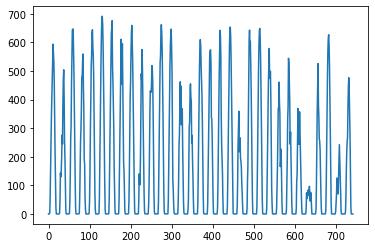

In [31]:
plt.plot(ssr[:,2,2])

In [130]:
## COMPUTE MRT
Istar = np.zeros_like(cos_phi0)

for i in range(len(time_utc)-1):
    for j in range(len(lons)):
        for k in range(len(lats)):
            if cos_phi0[i,j,k] > 0:
                # convert to W/m^2 from J/m^2
                if cos_phi[i,j,k] <= 0:
                    Istar[i,j,k] = 0.0
                else:
                    Istar[i,j,k] = fdir[i+1,j,k]/cos_phi0[i,j,k]/one_hour


alpha_ir = 0.7      # absorption coefficient of a human body
eps_p = 0.97        # emissivity coefficient of a human body
sigma = 5.67e-8     # stefan-boltzmann constant
fa = 0.5            # angle factors

MRT = ((fa*strd + fa*stru + alpha_ir/eps_p*(fa*(ssrd_diffusive+ssru)+fp*Istar))/sigma)**0.25-273.15

In [133]:
np.sum(MRT.mask,axis=(1,2))[:1000]

array([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 18, 12, 16,  9, 12, 20, 18,
       25, 25, 13,  0,  0, 17,  1,  0, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 18, 14,  5,  0,  7, 12, 13, 14, 24,  0,  0,  0,  0,  0, 10, 25,
       25, 13, 25, 23, 25, 25, 25, 25, 24, 12, 12,  5,  5,  0,  0, 17,  2,
        0,  0,  0,  2,  0,  0, 24, 24, 14, 25, 23,  9, 25, 25, 25,  6, 16,
       23, 10, 20, 19, 16,  4, 25,  0,  0,  4, 21,  0, 25, 18, 10, 24, 10,
       10, 22, 19, 25, 25,  8, 13,  7,  7,  0,  8, 12,  2, 22,  0,  0,  3,
        0,  0,  7,  0, 19, 23, 25,  5, 20, 25, 25, 25,  0, 11, 18, 24, 25,
        4,  4,  1,  8,  0,  0,  0,  0,  0, 21,  4,  4, 25, 25, 24, 16, 25,
       25, 25,  8,  7,  9, 25, 25, 22, 25,  3,  7,  0,  0,  0,  0,  0, 25,
       22, 18, 12,  9, 17, 25, 25, 25, 25,  6, 12, 17, 25,  2,  6,  0, 18,
       10,  0,  0,  0,  0,  0, 14, 12, 10,  6,  7, 25, 25, 25, 25, 25, 14,
        6,  6, 10, 21, 24, 22, 10,  3,  0,  0,  0,  0,  0, 25, 20, 25, 25,
       21, 13, 25,  7, 25

In [121]:
## COMPUTE UTCI
UTCI = np.zeros_like(MRT)        # UTCI
UTCIwind = np.zeros_like(MRT)    # UTCI with wind varying only, other variables default
UTCIrh = np.zeros_like(MRT)      # UTCI with relative humidity only, other variables default
UTCImrt = np.zeros_like(MRT)     # UTCI with radiation only, other variables default

for i in range(UTCI.shape[0]):
    for j in range(UTCI.shape[1]):
        for k in range(UTCI.shape[2]):
#             if T.mask[i+1,j,k] == False and MRT.mask[i,j,k] == False and wspd.mask[i+1,j,k] == False and rh.mask[i+1,j,k] == False:
                
                UTCI[i,j,k] = utci(T[i+1,j,k],MRT[i,j,k],wspd[i+1,j,k],rh[i+1,j,k])
                UTCIwind[i,j,k] = utci(T[i+1,j,k],T[i+1,j,k],wspd[i+1,j,k],50)
                UTCIrh[i,j,k] = utci(T[i+1,j,k],T[i+1,j,k],0.5,rh[i+1,j,k])
                UTCImrt[i,j,k] = utci(T[i+1,j,k],MRT[i,j,k],0.5,50)

TypeError: type MaskedConstant doesn't define __round__ method

In [107]:
## SAVE UTCI
np.savez(path+filename+"utci.npz",time=time,UTCI=UTCI,UTCIwind=UTCIwind,UTCIrh=UTCIrh,UTCImrt=UTCImrt)

In [108]:
# preallocate
ndays = (tend-tstart).days + 1
UTCI_dailymax = np.zeros(ndays)      # in the central grid box
UTCI_dailymean = np.zeros(ndays)
UTCI_3daymean = np.zeros(ndays)
UTCI_dailydiff = np.zeros(ndays)

# uncertainty
UTCI_dailymax0 = np.zeros(ndays)     # lowest max value in any grid box
UTCI_dailymax1 = np.zeros(ndays)     # highest max value in any grid box

UTCI_dailymean0 = np.zeros(ndays)    # highest mean value in any grid box
UTCI_dailymean1 = np.zeros(ndays)    # lowest max value in any grid box

UTCI_3daymean0 = np.zeros(ndays)     # lowest 3day mean value in any grid box
UTCI_3daymean1 = np.zeros(ndays)     # highest 3day mean value in any grid box

UTCI_dailydiff0 = np.zeros(ndays)    # lowest daily difference in mean UTCI in any grid box
UTCI_dailydiff1 = np.zeros(ndays)    # highest daily difference in mean UTCI in any grid box

In [109]:
# UTCI daily maximum and mean
for i in range(ndays):
    # pick data from respective day 9:00 to 21:00 local time
    itd = datetime.timedelta(days=i)
    iday = [t.date() == (tstart+itd).date() and t.hour > 8 and t.hour < 22 for t in time[1:]]
    UTCI_dailymax[i] = np.max(UTCI[iday,2,2])
    UTCI_dailymean[i] = np.mean(UTCI[iday,2,2])
    
    UTCI_dailymax0[i] = np.min(np.max(UTCI[iday,:,:],axis=0))
    UTCI_dailymax1[i] = np.max(np.max(UTCI[iday,:,:],axis=0))
    
    UTCI_dailymean0[i] = np.min(np.mean(UTCI[iday,:,:],axis=0))
    UTCI_dailymean1[i] = np.max(np.mean(UTCI[iday,:,:],axis=0))
    
    # 3-day mean
    # pick data from days i,i-1,i-2 at 9:00 to 21:00
    itd0 = datetime.timedelta(days=i-2)
    
    iday = [t.date() <= (tstart+itd).date() and
            t.date() >= (tstart+itd0).date() and
            t.hour > 8 and t.hour < 22 for t in time[1:]]
    
    UTCI_3daymean[i] = np.mean(UTCI[iday,2,2])
    UTCI_3daymean0[i] = np.min(np.mean(UTCI[iday,:,:],axis=0))
    UTCI_3daymean1[i] = np.max(np.mean(UTCI[iday,:,:],axis=0))
    
    # difference daily mean UTCI to previous day
    iday = [t.date() == (tstart+itd).date() and t.hour > 8 and t.hour < 22 for t in time[1:]]
    itd1 = datetime.timedelta(days=i-1)
    iprevday = [t.date() == (tstart+itd1).date() and t.hour > 8 and t.hour < 22 for t in time[1:]]
    
    UTCI_dailydiff[i] = np.mean(UTCI[iday,2,2]) - np.mean(UTCI[iprevday,2,2])
    UTCI_dailydiff0[i] = np.min(np.mean(UTCI[iday,:,:],axis=0) - np.mean(UTCI[iprevday,:,:],axis=0))
    UTCI_dailydiff1[i] = np.max(np.mean(UTCI[iday,:,:],axis=0) - np.mean(UTCI[iprevday,:,:],axis=0))
    

In [110]:
UTCI_dailymax

array([33.6, 36.5, 37.1, 36.8, 25.6, 21.6, 29.6])

In [111]:
# SAVE TO NPZ
np.savez(path+filename+"utci_daily.npz",UTCI_dailymax=UTCI_dailymax,
                                         UTCI_dailymean=UTCI_dailymean,
                                         UTCI_3daymean=UTCI_3daymean,
                                         UTCI_dailydiff=UTCI_dailydiff,
                                         UTCI_dailymax0=UTCI_dailymax0,
                                         UTCI_dailymax1=UTCI_dailymax1,
                                         UTCI_dailymean0=UTCI_dailymean0,
                                         UTCI_dailymean1=UTCI_dailymean1,
                                         UTCI_3daymean0=UTCI_3daymean0,
                                         UTCI_3daymean1=UTCI_3daymean1,
                                         UTCI_dailydiff0=UTCI_dailydiff0,
                                         UTCI_dailydiff1=UTCI_dailydiff1)

In [112]:
# SAVE TO CSV
fileout = open(path+"csv/"+filename+"utci_daily.csv","w")
fileout.write("Date,Day,Daily maximum UTCI [˚C],Daily mean UTCI [˚C],3-day mean UTCI [˚C],daily difference mean UTCI [˚C]\n")
for i in range(ndays):
    itd = datetime.timedelta(days=i)
    s = ",".join([str((tstart+itd).date()),
                  "{}".format(i+1),
                  "{:.4f}".format(UTCI_dailymax[i]),
                  "{:.4f}".format(UTCI_dailymean[i]),
                  "{:.4f}".format(UTCI_3daymean[i]),
                  "{:.4f}".format(UTCI_dailydiff[i])])
    fileout.write(s+"\n")

fileout.close()